In [100]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

In [2]:
import os
import json
import timeit
import shutil
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display
from collections import defaultdict, OrderedDict
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

%matplotlib inline

In [3]:
import sys, importlib
importlib.reload(sys.modules['Autoencoder_Utils'])

<module 'Autoencoder_Utils' from '/mnt/mivakhnenko/LHCb_PID_Compression/Autoencoder_Utils.py'>

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Считаем подготовленные для обучения автоэнкодера данные

In [4]:
%%time
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('Data/df.csv')

CPU times: user 30.3 s, sys: 4.12 s, total: 34.4 s
Wall time: 34.1 s


In [5]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

c    545384
f    545384
b    545384
d    545384
a    545384
e    545384
Name: pid, dtype: int64


In [6]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

In [7]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    elif 'mask' not in v: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

34 variables to compress


Добавим маску

In [8]:
%%time
df['mask'] = [pd.isnull(line) ^ True for line in df[vars_list_input].values]

CPU times: user 53.4 s, sys: 3.37 s, total: 56.8 s
Wall time: 56.3 s


CPU times: user 25.8 s, sys: 9.51 s, total: 35.3 s
Wall time: 24.5 s


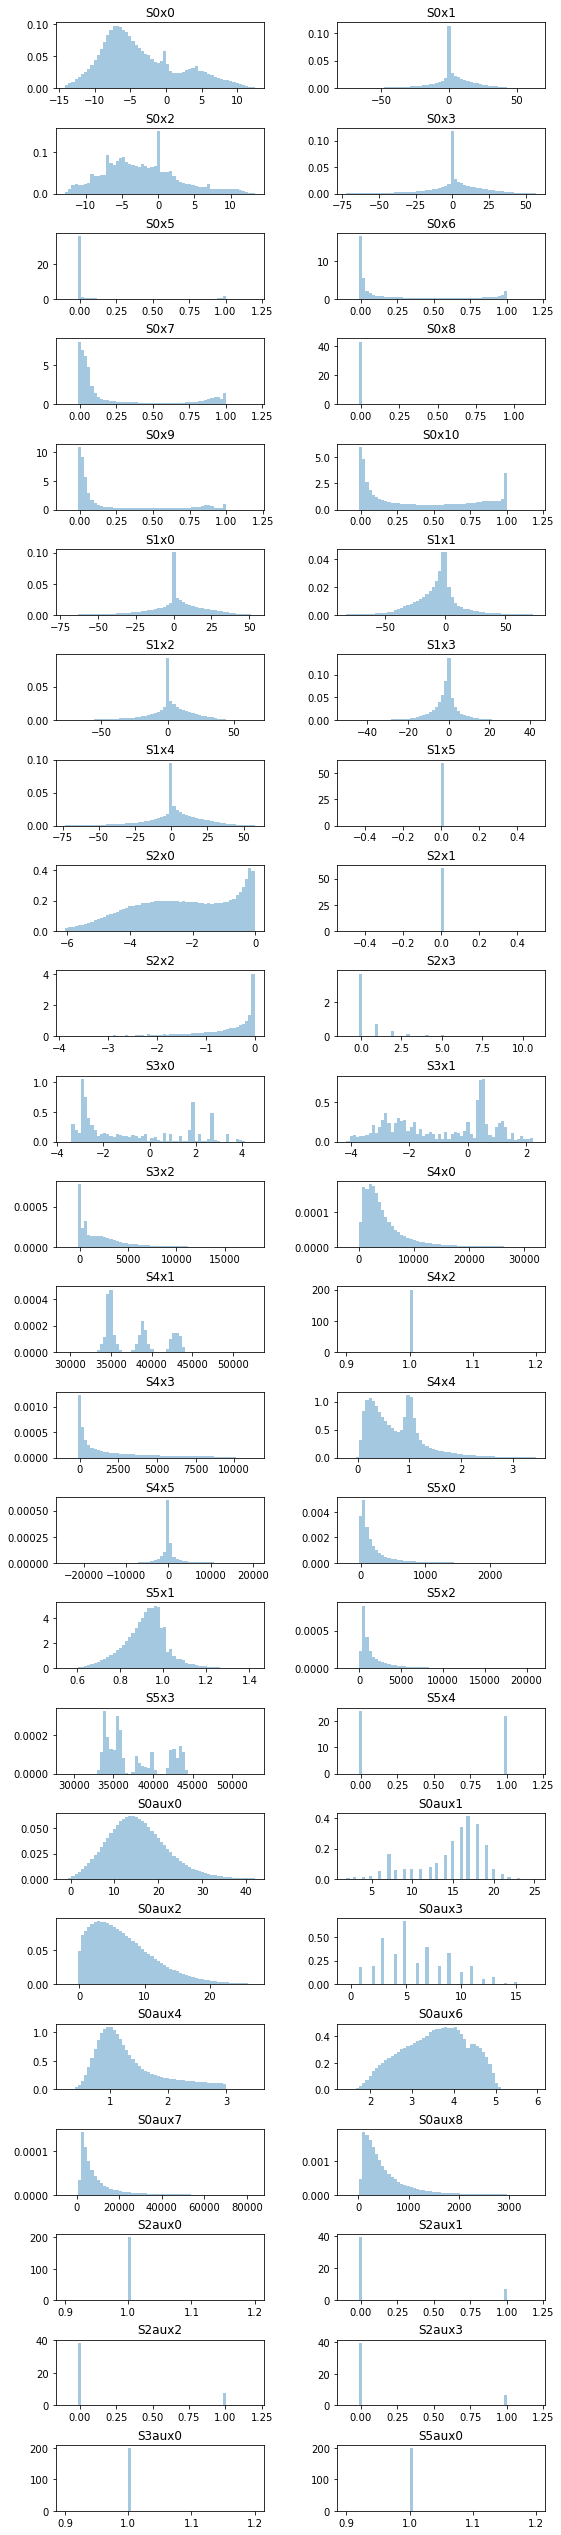

In [9]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# Разобъем индексы на train и test

In [10]:
# train test split
train_size = 0.7
test_size = 0.3
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [11]:
df.shape, idx_train.shape, idx_test.shape

((3272304, 50), (2290612,), (981692,))

## Переведем значения признаков в отрезок $[-1, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [12]:
df_scaled = df.copy()

In [13]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    cur_idx_without_nan = pd.isnull(df[var]) ^ True
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = std_scaler.transform(
        df[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    
    # normalize with MaxAbsScaler
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = max_scaler.transform(
        df_scaled[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CPU times: user 41.5 s, sys: 1.78 s, total: 43.2 s
Wall time: 42.9 s


CPU times: user 23.6 s, sys: 9.03 s, total: 32.6 s
Wall time: 22.6 s


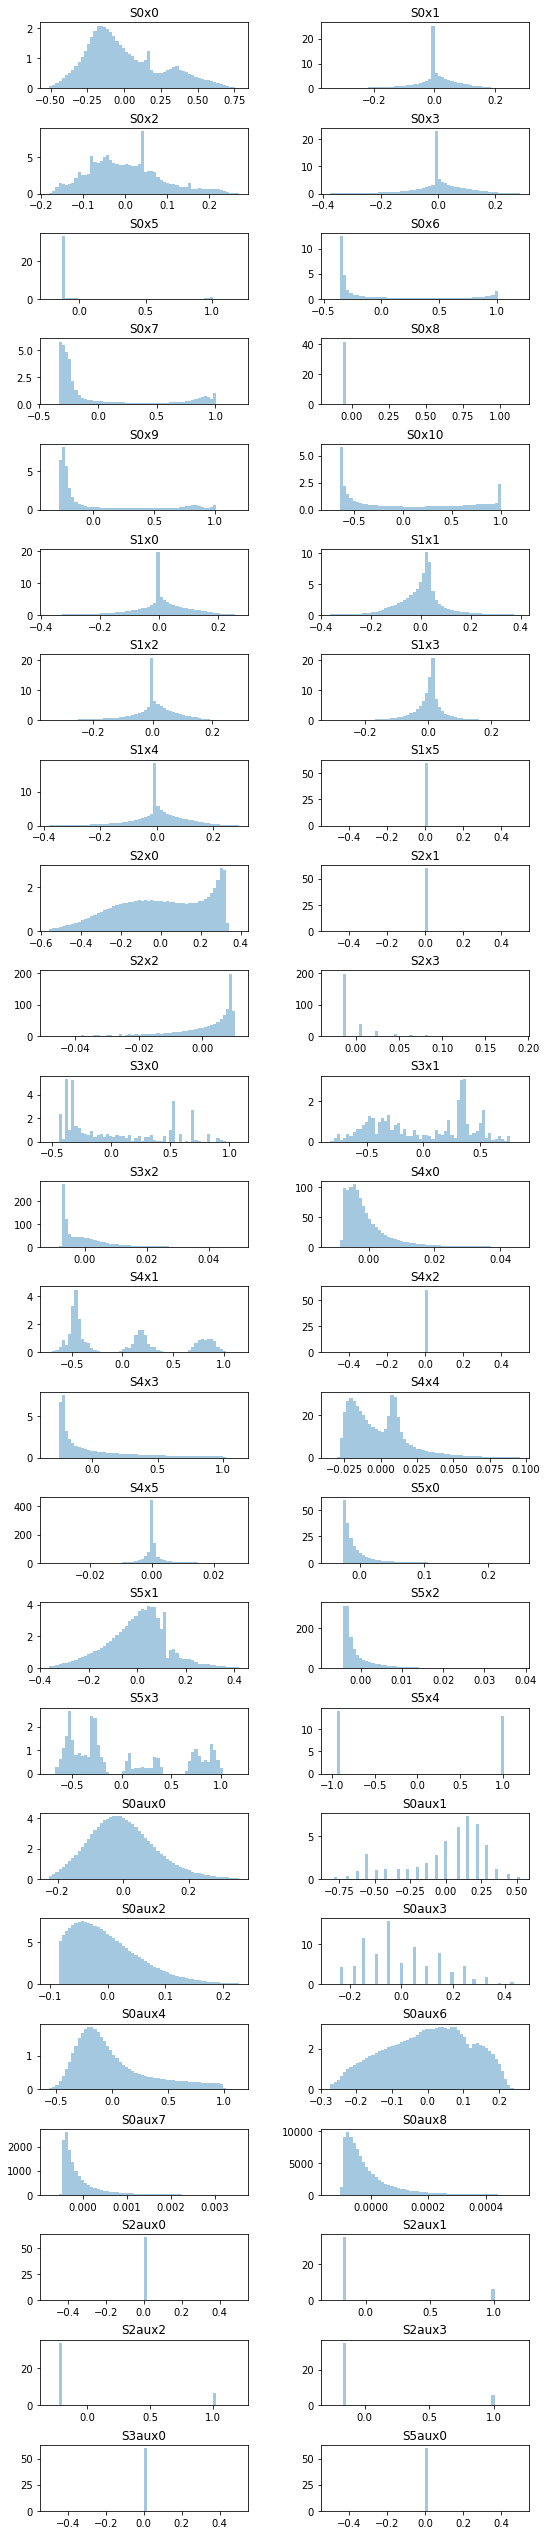

In [14]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

## Восстановим эмпирическое распределение по фичам

Чтобы можно было сэмплить из него, когда хотим заменить None(может выйти лучше, че просто нулями заполнять)

In [170]:
l_encoding_dim = [1, 3, 6, 9, 12, 15, 18]
n_compressed_features = len(vars_list_input)
n_aux_features = len(vars_list_aux)
n_features = n_compressed_features + n_aux_features
val_size = 0.1

# train = df_scaled.fillna(value=0).iloc[idx_train]
# test = df_scaled.fillna(value=0).iloc[idx_test]

train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]

train_input = train[vars_list_input].values
train_aux   = train[vars_list_aux].values
train_MC    = train[vars_list_MC].values
train_mask  = np.concatenate(df['mask'].iloc[idx_train].values).reshape((-1, n_compressed_features))

test_input = test[vars_list_input].values
test_aux   = test[vars_list_aux].values
test_MC    = test[vars_list_MC].values
test_mask  = np.concatenate(df['mask'].iloc[idx_test].values).reshape((-1, n_compressed_features))

In [17]:
2100 * 8 / 60 / 60

4.666666666666667

In [18]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

In [25]:
%%time
# calculate GMM
n_components = 4
gmm_dict = {}
for var in tqdm(vars_list_input + vars_list_aux):
    gmm_dict[var] = GaussianMixture(n_components=n_components, n_init=3, covariance_type="full", verbose=0)
    gmm_dict[var].fit(train[var].dropna().values.reshape(-1, 1))
    print("Var: ", var, " BIC: ", gmm_dict[var].bic(train[var].dropna().values.reshape(-1, 1)))

  3%|▎         | 1/34 [00:49<27:24, 49.83s/it]

Var:  S0x0  BIC:  -99363.36527080364


  6%|▌         | 2/34 [04:08<50:20, 94.40s/it]

Var:  S0x1  BIC:  -6774692.725363202


  9%|▉         | 3/34 [04:56<41:38, 80.61s/it]

Var:  S0x2  BIC:  -4946503.417138794


 12%|█▏        | 4/34 [07:59<55:36, 111.21s/it]

Var:  S0x3  BIC:  -6228514.397993567


 15%|█▍        | 5/34 [10:21<58:15, 120.54s/it]

Var:  S0x5  BIC:  -17012223.096064113


 18%|█▊        | 6/34 [12:53<1:00:34, 129.82s/it]

Var:  S0x6  BIC:  -4005264.323541725


 21%|██        | 7/34 [13:51<48:44, 108.31s/it]  

Var:  S0x7  BIC:  -2322812.031018187


 24%|██▎       | 8/34 [14:28<37:44, 87.09s/it] 

Var:  S0x8  BIC:  -22625063.14784582


 26%|██▋       | 9/34 [16:43<42:11, 101.26s/it]

Var:  S0x9  BIC:  -3482195.6140235327


 29%|██▉       | 10/34 [19:27<48:03, 120.15s/it]

Var:  S0x10  BIC:  1155612.1599103953


 32%|███▏      | 11/34 [22:08<50:43, 132.34s/it]

Var:  S1x0  BIC:  -5610580.466435908


 35%|███▌      | 12/34 [23:12<40:59, 111.81s/it]

Var:  S1x1  BIC:  -4817891.564668032


 38%|███▊      | 13/34 [25:59<45:01, 128.64s/it]

Var:  S1x2  BIC:  -6201735.034885569


 41%|████      | 14/34 [27:55<41:34, 124.73s/it]

Var:  S1x3  BIC:  -7452329.662780797


 44%|████▍     | 15/34 [30:20<41:25, 130.84s/it]

Var:  S1x4  BIC:  -5458138.689139074


 47%|████▋     | 16/34 [34:25<49:31, 165.10s/it]

Var:  S1x5  BIC:  -27435949.919732288


 50%|█████     | 17/34 [35:03<35:59, 127.02s/it]

Var:  S2x0  BIC:  -22092792.295727294


 53%|█████▎    | 18/34 [39:07<43:12, 162.03s/it]

Var:  S2x1  BIC:  -27435949.919732288


 56%|█████▌    | 19/34 [39:44<31:06, 124.42s/it]

Var:  S2x2  BIC:  -24317162.515678875


 59%|█████▉    | 20/34 [40:27<23:19, 100.00s/it]

Var:  S2x3  BIC:  -24611825.118149087


 62%|██████▏   | 21/34 [41:43<20:07, 92.92s/it] 

Var:  S3x0  BIC:  -2895301.0161619284


 65%|██████▍   | 22/34 [43:00<17:37, 88.14s/it]

Var:  S3x1  BIC:  -1786463.926028989


 68%|██████▊   | 23/34 [44:05<14:53, 81.26s/it]

Var:  S3x2  BIC:  -17538025.64758612


 71%|███████   | 24/34 [45:15<12:57, 77.77s/it]

Var:  S4x0  BIC:  -18582467.52172465


 74%|███████▎  | 25/34 [45:47<09:37, 64.17s/it]

Var:  S4x1  BIC:  -6870913.527162247


 76%|███████▋  | 26/34 [49:52<15:45, 118.20s/it]

Var:  S4x2  BIC:  -27435949.919732288


 79%|███████▉  | 27/34 [53:58<18:17, 156.78s/it]

Var:  S4x3  BIC:  -8429796.799679037


 82%|████████▏ | 28/34 [55:04<12:57, 129.54s/it]

Var:  S4x4  BIC:  -13371708.02740735


 85%|████████▌ | 29/34 [56:25<09:34, 114.92s/it]

Var:  S4x5  BIC:  -21786196.759940945


 88%|████████▊ | 30/34 [57:35<06:44, 101.25s/it]

Var:  S5x0  BIC:  -12781132.05571308


 91%|█████████ | 31/34 [58:50<04:40, 93.39s/it] 

Var:  S5x1  BIC:  -6146885.185532612


 94%|█████████▍| 32/34 [1:00:01<02:53, 86.64s/it]

Var:  S5x2  BIC:  -20112304.256255254


 97%|█████████▋| 33/34 [1:00:25<01:08, 68.03s/it]

Var:  S5x3  BIC:  1103993.9258625559


100%|██████████| 34/34 [1:00:38<00:00, 51.50s/it]

Var:  S5x4  BIC:  -22533459.598024238
CPU times: user 1h 44min 54s, sys: 2h 46min 56s, total: 4h 31min 51s
Wall time: 1h 38s


In [56]:
vars_list_aux[7]

'S0aux8'

    # generate data
X_gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                         size=ceil(gm.weights_[0] * n_samples)))
for d in range(1, gm.n_components):
    X_gen=np.vstack((
        X_gen, 
        multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=ceil(gm.weights_[d]*n_samples))
    ))

    # Сэмплирование
    def sampling(args):
        input_compressible, mask, gmm_dict = args
        res = input_compressible.copy()
        for i, var in enumerate(gmm_dict.keys()):
            if not mask[i]:
                cur_val = 0
                for d in range(gmm_dict[var].n_components):
                    cur_val += (
                        K.random_normal(shape=(1, ), mean=gmm_dict[var].means_[d], 
                                        stddev=gmm_dict[var].covariances_[d])[0]
                        * gmm_dict[var].weights_[d]
                    )
                res[i] = cur_val
        return res
    l = Lambda(sampling, output_shape=(latent_dim,))([input_compressible, mask, gmm_dict])

### Сгруппируем детекторы

In [19]:
detectors_groups_dict = OrderedDict({
    'S' + str(i): [var for var in vars_list_input if var[1] == str(i)] for i in range(6)
})
detectors_groups_dict.update({
    'S' + str(i) + 'aux': [var for var in vars_list_aux if var[1] == str(i)] for i in [0, 2, 3, 5]
})

In [20]:
detectors_groups_dict

OrderedDict([('S0',
              ['S0x0',
               'S0x1',
               'S0x2',
               'S0x3',
               'S0x5',
               'S0x6',
               'S0x7',
               'S0x8',
               'S0x9',
               'S0x10']),
             ('S1', ['S1x0', 'S1x1', 'S1x2', 'S1x3', 'S1x4', 'S1x5']),
             ('S2', ['S2x0', 'S2x1', 'S2x2', 'S2x3']),
             ('S3', ['S3x0', 'S3x1', 'S3x2']),
             ('S4', ['S4x0', 'S4x1', 'S4x2', 'S4x3', 'S4x4', 'S4x5']),
             ('S5', ['S5x0', 'S5x1', 'S5x2', 'S5x3', 'S5x4']),
             ('S0aux',
              ['S0aux0',
               'S0aux1',
               'S0aux2',
               'S0aux3',
               'S0aux4',
               'S0aux6',
               'S0aux7',
               'S0aux8']),
             ('S2aux', ['S2aux0', 'S2aux1', 'S2aux2', 'S2aux3']),
             ('S3aux', ['S3aux0']),
             ('S5aux', ['S5aux0'])])

In [21]:
detectors_groups_dict.values()

odict_values([['S0x0', 'S0x1', 'S0x2', 'S0x3', 'S0x5', 'S0x6', 'S0x7', 'S0x8', 'S0x9', 'S0x10'], ['S1x0', 'S1x1', 'S1x2', 'S1x3', 'S1x4', 'S1x5'], ['S2x0', 'S2x1', 'S2x2', 'S2x3'], ['S3x0', 'S3x1', 'S3x2'], ['S4x0', 'S4x1', 'S4x2', 'S4x3', 'S4x4', 'S4x5'], ['S5x0', 'S5x1', 'S5x2', 'S5x3', 'S5x4'], ['S0aux0', 'S0aux1', 'S0aux2', 'S0aux3', 'S0aux4', 'S0aux6', 'S0aux7', 'S0aux8'], ['S2aux0', 'S2aux1', 'S2aux2', 'S2aux3'], ['S3aux0'], ['S5aux0']])

## Зададим архитектуру автоэнкодера

In [59]:
def nan2random(particle):
    return tf.map_fn(lambda pair: # var, elem
                     tf.cond(tf.is_nan(pair[1]),
                             K.sum((
                                 K.random_normal(
                                     shape=(1, ), mean=gmm_dict[pair[0]].means_[d],
                                     stddev=gmm_dict[pair[0]].covariances_[d])[0] * gmm_dict[pair[0]].weights_[d]
                                 for d in range(gmm_dict[pair[0]].n_components))),
                             pair[1]), tf.zip(tf.convert_to_tensor(list(gmm_dict.keys()), dtype=str), particle))

In [83]:
a = np.array([None, 1, 2, 3, 4, None], dtype=np.float64).reshape((-1, 3))
np.where(np.isnan(a), np.zeros_like(a), a)

array([[0., 1., 2.],
       [3., 4., 0.]])

In [84]:
a

array([[nan,  1.,  2.],
       [ 3.,  4., nan]])

In [206]:
def penalized_loss(mask):
    def loss(y_true, y_pred):
        return K.mean(K.square(tf.boolean_mask(y_pred, mask) - tf.boolean_mask(y_true, mask)), axis=-1)
    return loss


def create_autoencoder_with_sample(n_compressed_features, n_aux_features, detectors_groups_dict,
                                   encoding_dim, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_compressed_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    mask = Input(shape=(n_compressed_features, ), name='mask', dtype=bool)
    
    encoder_input_with_nan = keras.layers.concatenate([inputs, aux_inputs])
    
    # None -> 0
    def replace_nan_to_zero(encoder_input):
        return tf.where(tf.is_nan(encoder_input), tf.zeros_like(encoder_input), encoder_input)

    encoder_input = Lambda(replace_nan_to_zero, output_shape=(n_compressed_features + n_aux_features, ))(
        encoder_input_with_nan
    )
    x = encoder_input
#     x = K.tf.where(tf.is_nan(encoder_input), tf.zeros_like(encoder_input), encoder_input)
    for i in range(n_layers - 1):
        x = Dense(thickness * (n_compressed_features + n_aux_features), activation='tanh')(x)
#         x = keras.layers.concatenate([x, aux_inputs])

#     x = Dropout(p_drop)(x)
    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = keras.layers.concatenate([x, aux_inputs])
#     x = Dropout(p_drop)(x)
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Lambda(replace_nan_to_zero, output_shape=(encoding_dim + n_aux_features, ))(x)
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = Dropout(p_drop)(x)
    
    for i in range(n_layers - 1):
#         x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * (n_compressed_features + n_aux_features), activation='tanh')(x)
        
#     x = Dropout(p_drop)(x)
    decoded = Dense(n_compressed_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs, mask], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )
    
    # Double
    # None -> decoded
    def replace_nan_to_decoded(args):
        encoder_input, decoded = args
        return tf.where(tf.is_nan(encoder_input), decoded, encoder_input)
    
    double_encoder_input_raw = keras.layers.concatenate([autoencoder([inputs, aux_inputs, mask]), aux_inputs])
    double_encoder_input_raw = Lambda(replace_nan_to_zero, output_shape=(n_compressed_features + n_aux_features, ))(
        double_encoder_input_raw
    )
    double_encoder_input = Lambda(replace_nan_to_decoded, output_shape=(n_compressed_features + n_aux_features, ))(
        [encoder_input_with_nan, double_encoder_input_raw]
    )
    
    def split_layer_input(double_encoder_input):
        double_input, double_aux = tf.split(double_encoder_input, [n_compressed_features, n_aux_features], axis=1)
        return double_input
    
    def split_layer_aux(double_encoder_input):
        double_input, double_aux = tf.split(double_encoder_input, [n_compressed_features, n_aux_features], axis=1)
        return double_aux
    double_input = Lambda(split_layer_input)(double_encoder_input)
    double_aux = Lambda(split_layer_aux)(double_encoder_input)
    
    # enc
    double_encoded = Lambda(lambda args: encoder(args), output_shape=(encoding_dim, ))([double_input, double_aux])
    
    # Модели
    double_encoder = Model(
        [inputs, aux_inputs, mask], double_encoded, 
        name="double_encoder")
    double_autoencoder = Model(
        [inputs, aux_inputs, mask], decoder([double_encoder([inputs, aux_inputs, mask]), aux_inputs]), 
        name="double_autoencoder")
    
    optimizer_adam = Adam(lr=0.001)
#     loss = K.sum(K.square(autoencoder.output - encoder_input)[mask], axis=-1)
    double_autoencoder.compile(loss=penalized_loss(mask), optimizer=optimizer_adam)
    
    return double_autoencoder, double_encoder, decoder

## Обучим автоэнкодер

In [214]:
nb_epoch = 30
batch_size = 128
n_layers = 3
thickness = 2

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}
l_score = []

In [215]:
n_repeats_autoencoder = np.ones_like(l_encoding_dim, dtype=int)
n_evals_for_autoencoder = np.zeros_like(l_encoding_dim, dtype=int)

In [ ]:
%%time
while np.sum(n_repeats_autoencoder - n_evals_for_autoencoder) > 0:
    for i, encoding_dim in tqdm(enumerate(l_encoding_dim)):
        if n_evals_for_autoencoder[i] >= n_repeats_autoencoder[i]:
            continue
        
        print("encoding_dim : ", encoding_dim)
        autoencoder, encoder, decoder = create_autoencoder_with_sample(
            n_compressed_features, n_aux_features, detectors_groups_dict,
            encoding_dim, n_layers=n_layers, thickness=thickness
        )

        # Fit model
        start_time = timeit.default_timer()
        history = autoencoder.fit(
            [train_input, train_aux, train_mask], train_input,
#             [inpt for inpt in train_input.values()] + [inpt for inpt in train_aux.values()] + [train_mask],
#             np.concatenate([inpt for inpt in train_input.values()], axis=1),
            epochs=nb_epoch, batch_size=batch_size,
            shuffle=True, verbose=1,
            validation_split=val_size, callbacks = [early_stopping, tensorboard]
        )
        
        # Predict
        score = autoencoder.evaluate(
            [test_input, test_aux, test_mask], test_input,
#             [inpt for inpt in test_input.values()] + [inpt for inpt in test_aux.values()] + [test_mask],
#             np.concatenate([inpt for inpt in test_input.values()], axis=1), 
            batch_size=batch_size
        )
        encoded_test = encoder.predict(
            [test_input, test_aux, test_mask]
#             [inpt for inpt in test_input.values()] + [inpt for inpt in test_aux.values()] + [test_mask]
        )
        decoded_test = decoder.predict(
            [encoded_test, test_aux]
#             [encoded_test] + [inpt for inpt in test_aux.values()]
        ) # test mode = 0
        run_time = timeit.default_timer() - start_time

        # Save
        save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
        save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)
        l_score.append(score)
        n_evals_for_autoencoder[i] += 1

        # Plot
        print("Run time: {:.2f} sec".format(run_time))
        print('n_evals_for_autoencoder: ', n_evals_for_autoencoder)
        plt.plot(history.history['loss'], "b")
        plt.plot(history.history['val_loss'], "r")
        plt.show()
        print("\n\n")


0it [00:00, ?it/s]

encoding_dim :  1


/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2061550 samples, validate on 229062 samples


Epoch 1/30
2061550/2061550 [==============================] - 184s 89us/step - loss: 0.0404 - val_loss: 0.0330
Epoch 2/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 0.0352 - val_loss: 0.0300
Epoch 3/30
1250304/2061550 [=================>............] - ETA: 1:09 - loss: 0.0339

In [217]:
import datetime
now = datetime.datetime.now()

print(now)

2018-07-19 14:37:25.600213


In [218]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 34)           0                                            
__________________________________________________________________________________________________
aux_inputs (InputLayer)         (None, 14)           0                                            
__________________________________________________________________________________________________
mask (InputLayer)               (None, 34)           0                                            
__________________________________________________________________________________________________
double_encoder (Model)          (None, 18)           35524       main_input[0][0]                 
                                                                 aux_inputs[0][0]                 
          

In [219]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 34)           0                                            
__________________________________________________________________________________________________
aux_inputs (InputLayer)         (None, 14)           0                                            
__________________________________________________________________________________________________
mask (InputLayer)               (None, 34)           0                                            
__________________________________________________________________________________________________
autoencoder (Model)             (None, 34)           35524       main_input[0][0]                 
                                                                 aux_inputs[0][0]                 
          

In [220]:
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
aux_inputs (InputLayer)         (None, 14)           0                                            
__________________________________________________________________________________________________
concatenate_119 (Concatenate)   (None, 32)           0           input_45[0][0]                   
                                                                 aux_inputs[0][0]                 
__________________________________________________________________________________________________
lambda_156 (Lambda)             (None, 32)           0           concatenate_119[0][0]            
__________

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

## Сохраненим score, сжимаемые переменные, test и decoded(после обратного масштабирования)

In [240]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input
retain_dict['test_mask'] = test_mask

In [241]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [242]:
np.isnan(test_input[:, i])

array([ True,  True,  True, ...,  True,  True, False])

In [243]:
%%time
for i, var in enumerate(vars_list_input):
    cur_idx_without_nan = np.isnan(test_input[:, i]) ^ True
    test_input_unslaced[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[cur_idx_without_nan, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    cur_idx_without_nan = np.isnan(test_aux[:, i]) ^ True
    test_aux_unslaced[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[cur_idx_without_nan, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

CPU times: user 1.54 s, sys: 56 ms, total: 1.6 s
Wall time: 1.57 s


In [244]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        cur_idx_without_nan = np.isnan(tmp_decoded_unscaled[:, i]) ^ True
        tmp_decoded_unscaled[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[cur_idx_without_nan, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [249]:
pickle.dump(retain_dict, open("retain_dict_{}.p".format(TYPE), "wb"))

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [250]:
# Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

pids = ['a', 'b', 'c', 'd', 'e']

retain_dict = pickle.load( open( "retain_dict_{}.p".format(TYPE), "rb" ) )
test_input = retain_dict.pop("test_input")
test_input_dec = retain_dict.pop("test_input_dec")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")
test_mask = retain_dict.pop("test_mask")
l_score = retain_dict.pop("l_score")
save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")
vars_list_input = retain_dict.pop("vars_list_input")

l_encoding_dim = list(save_decoded_dict.keys())

Распределение ошибки предсказаний автоэнкодера

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CPU times: user 2min 3s, sys: 38.3 s, total: 2min 41s
Wall time: 2min 8s


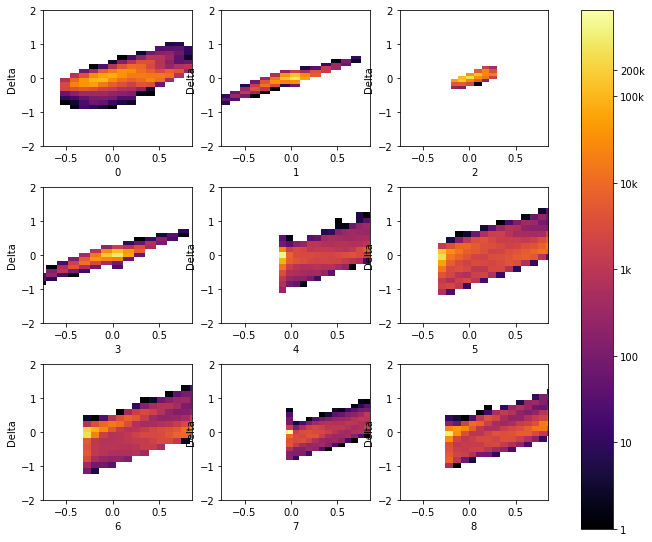

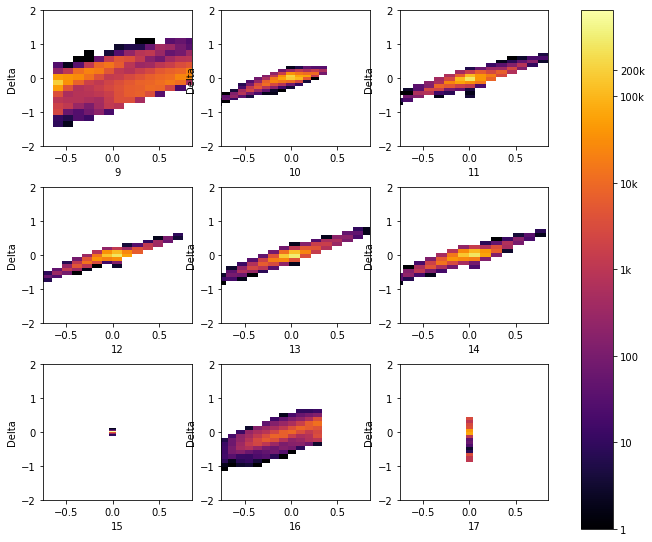

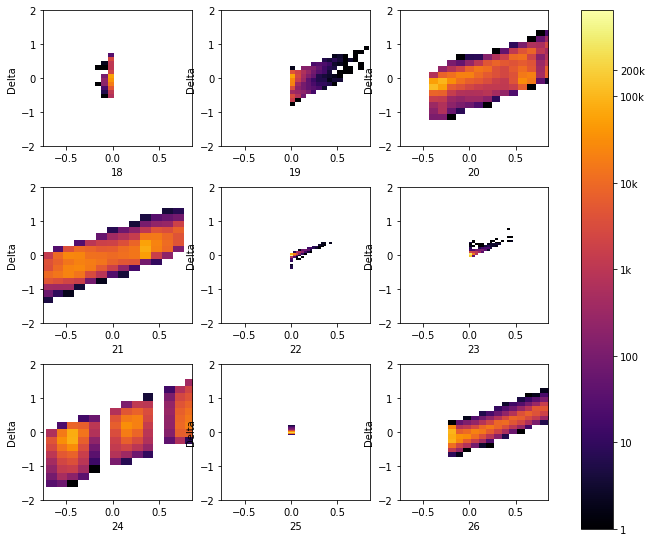

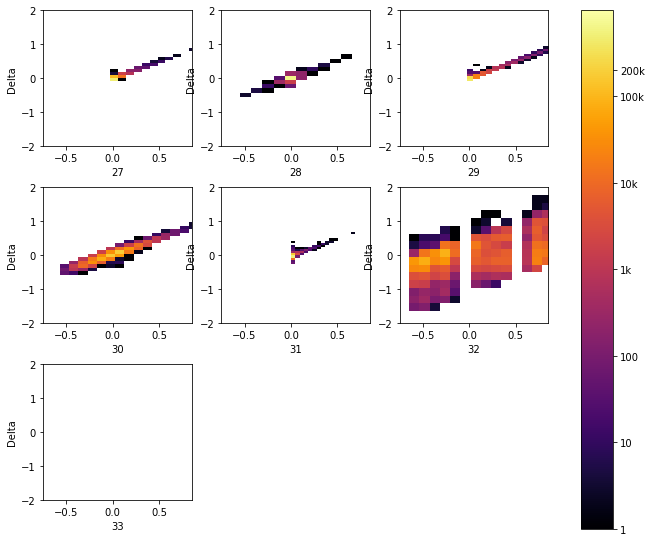

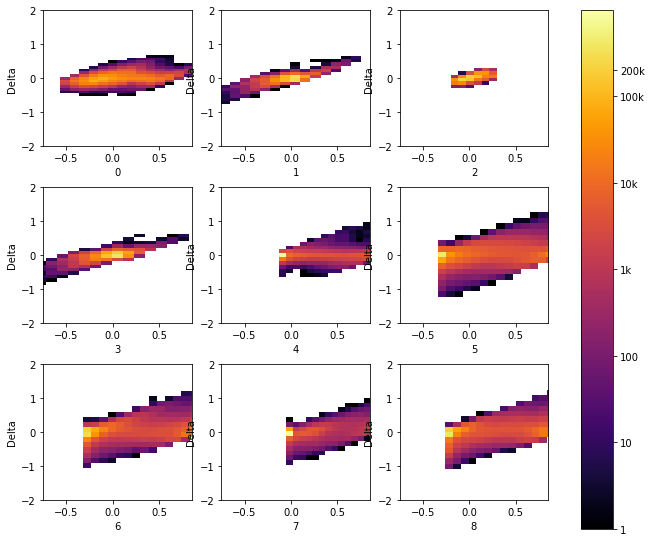

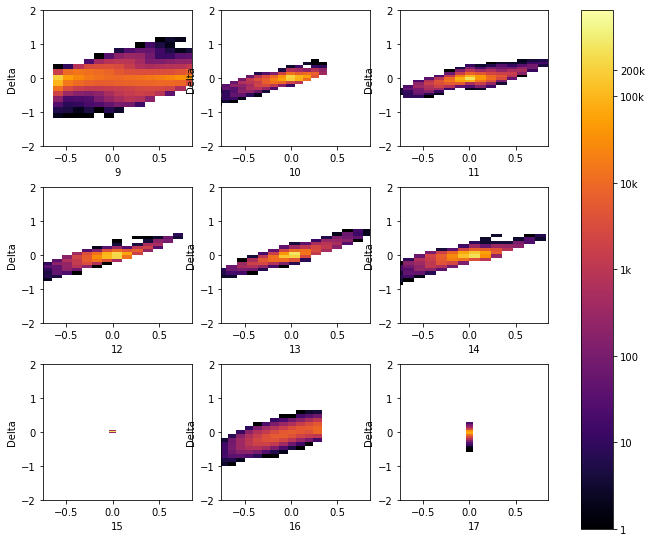

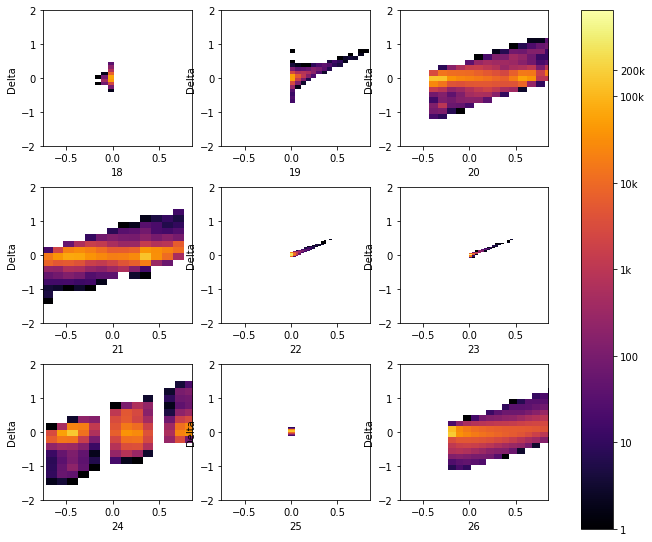

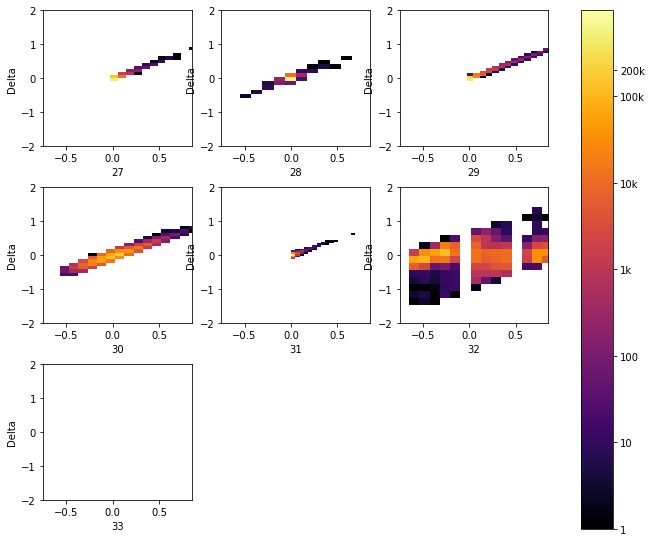

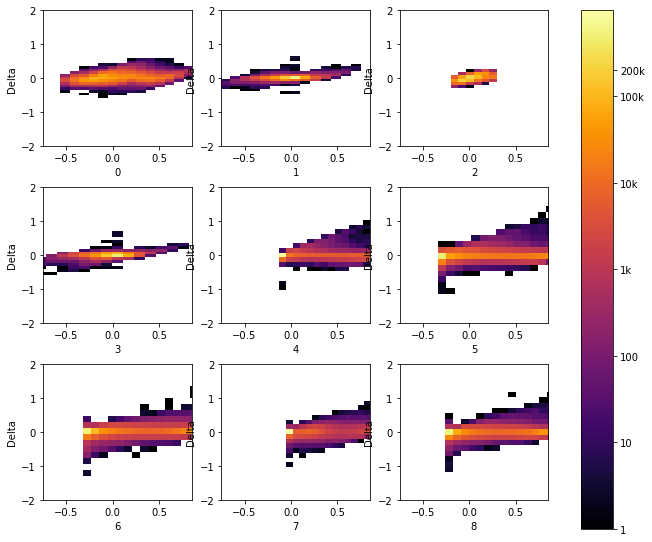

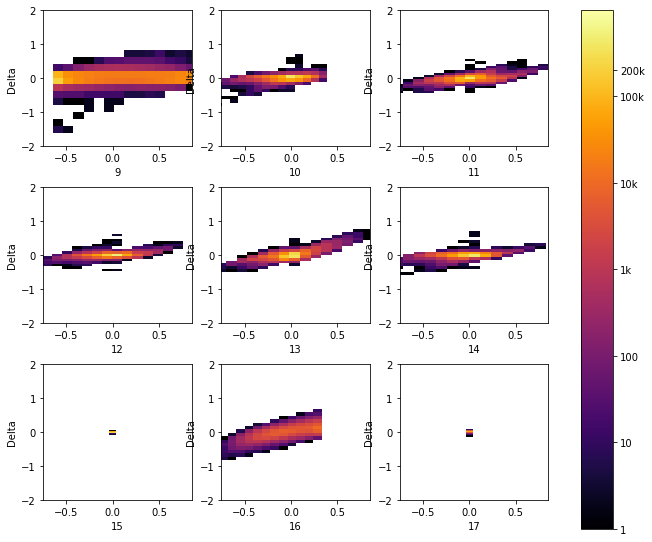

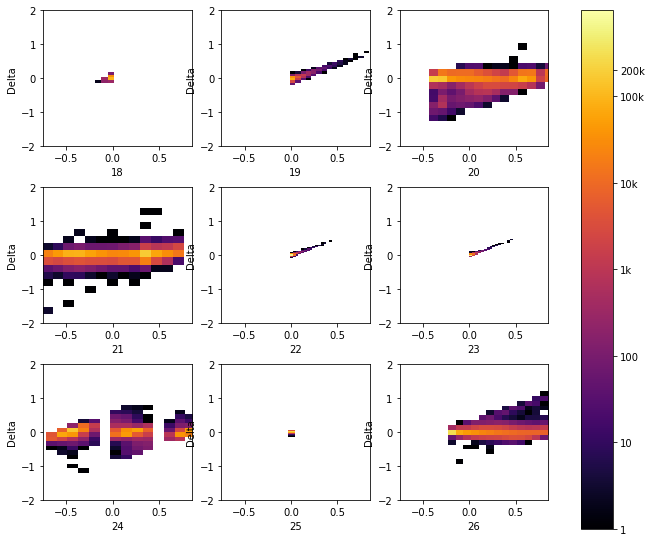

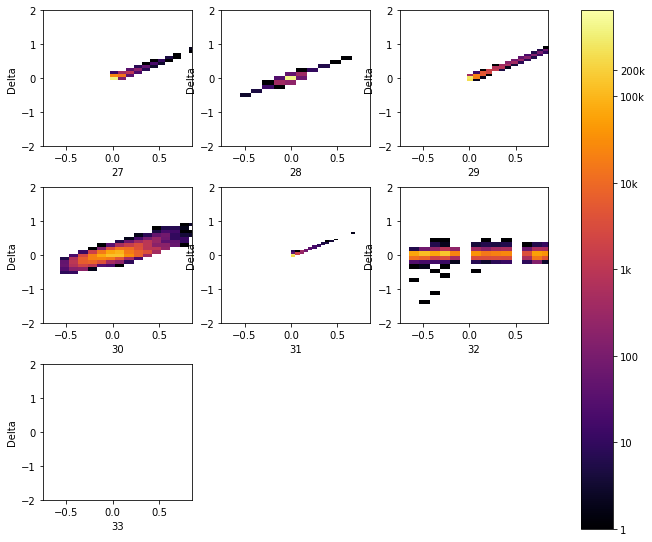

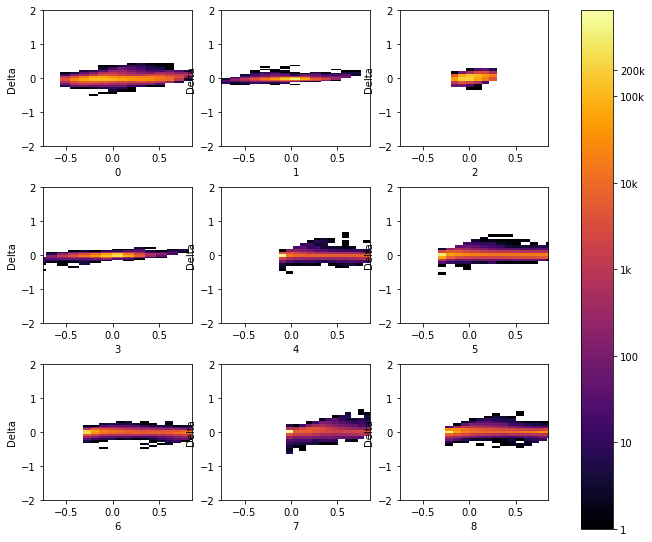

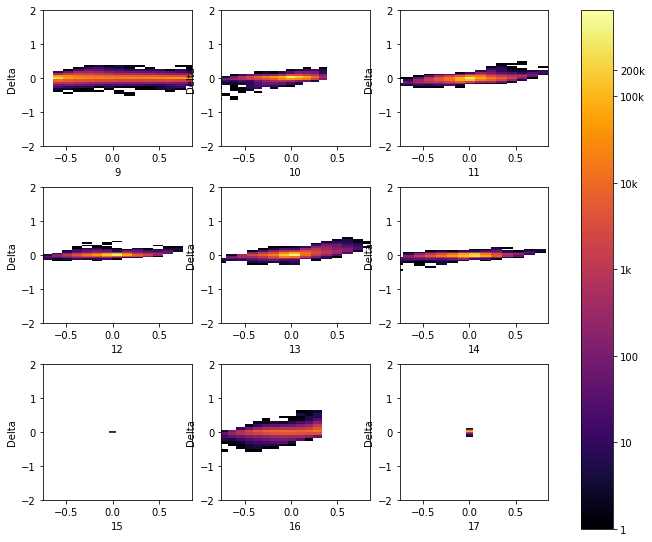

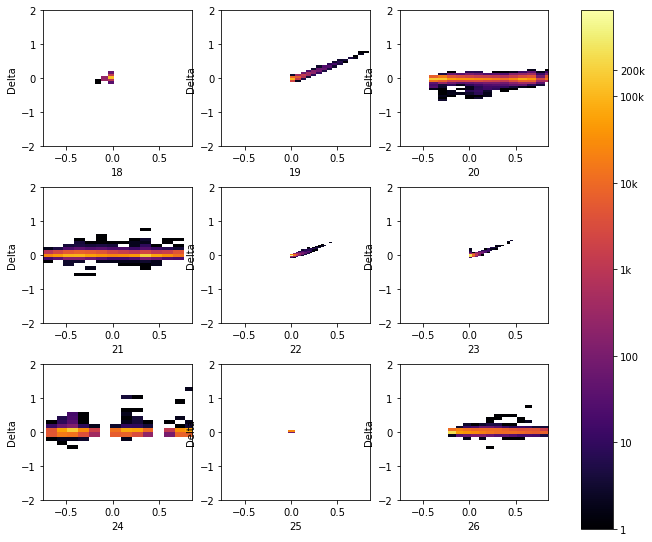

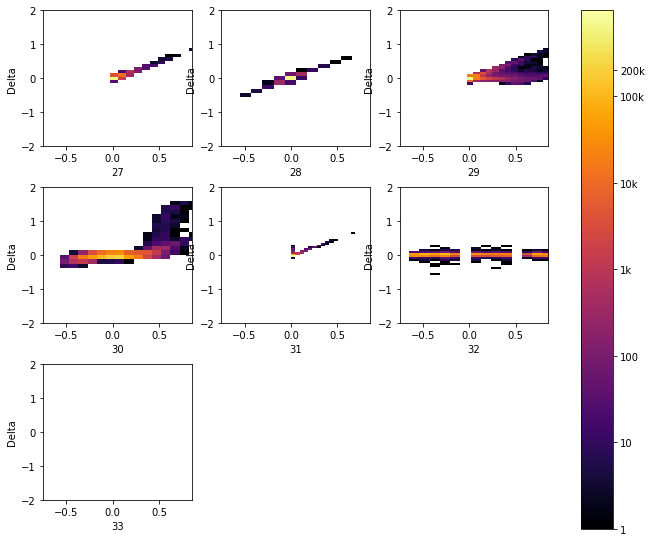

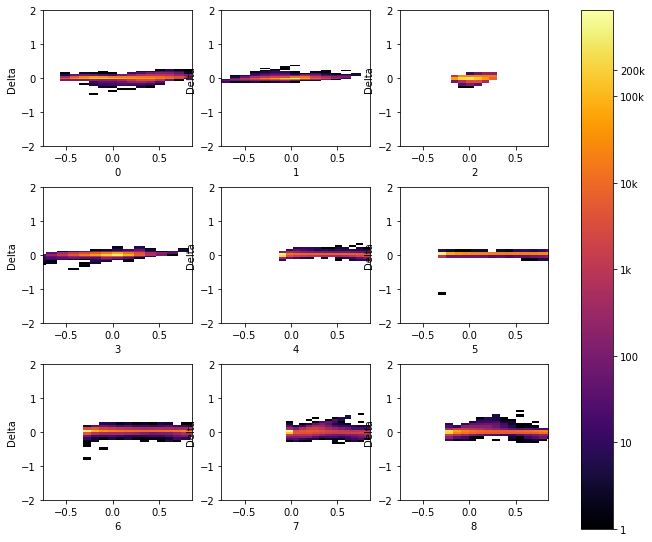

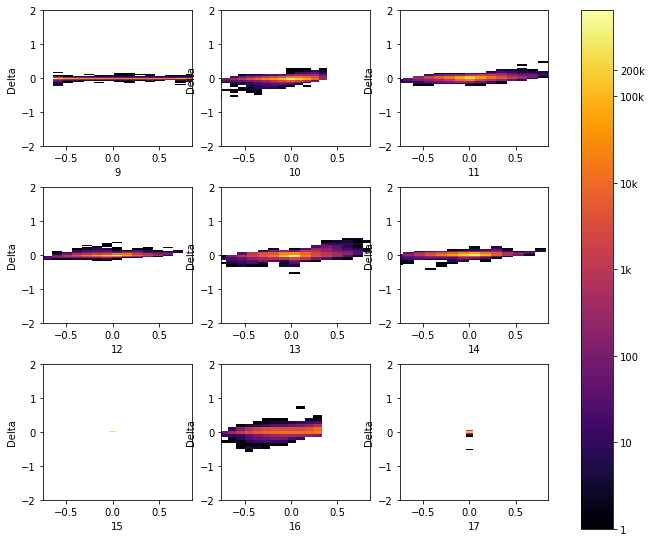

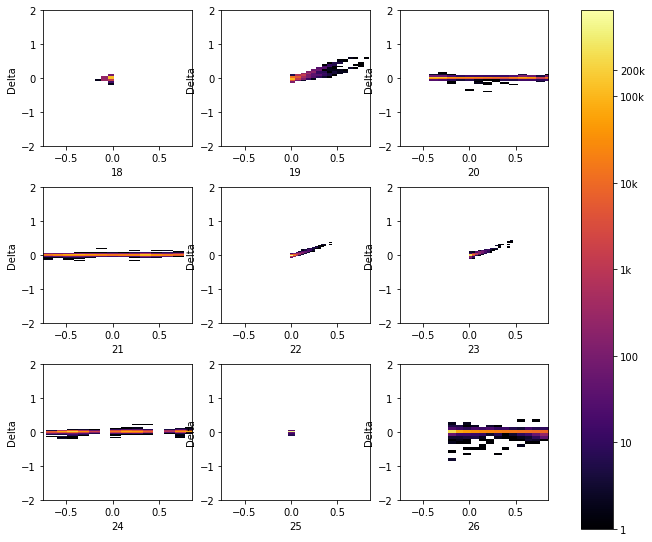

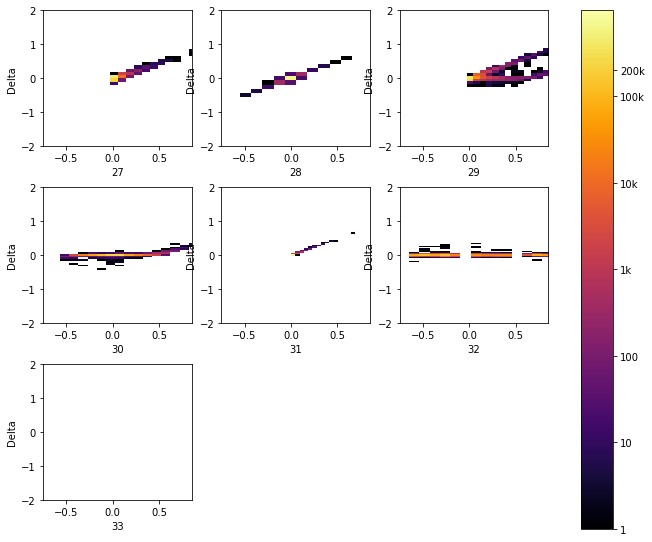

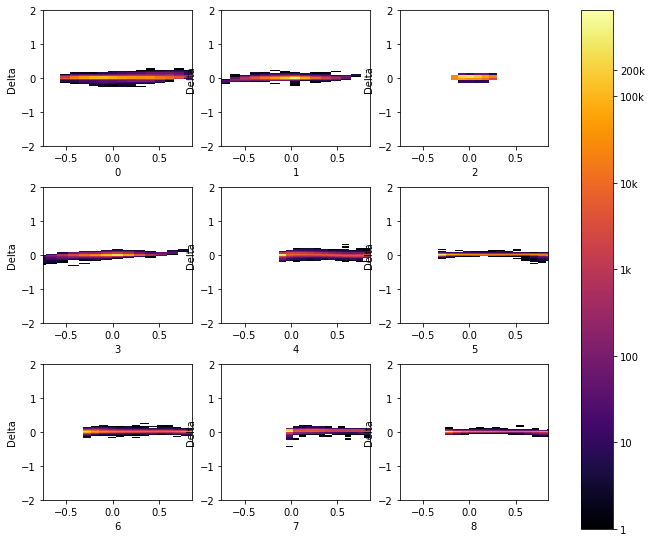

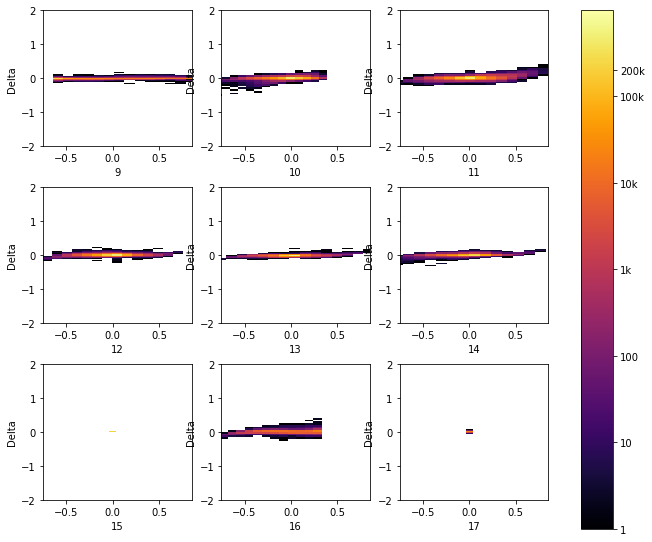

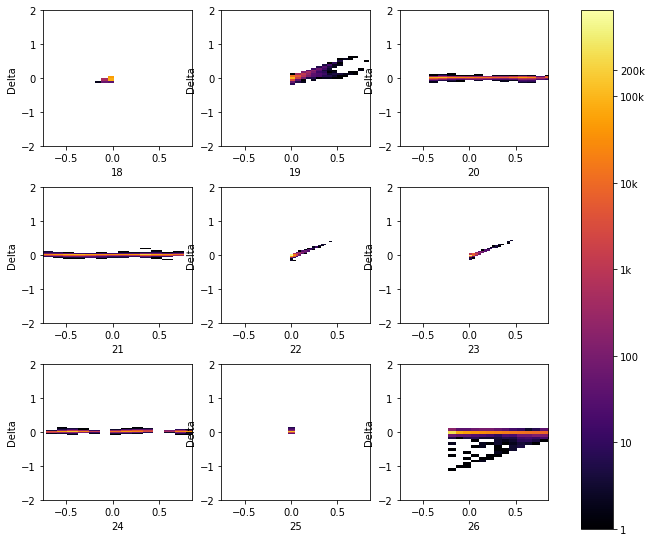

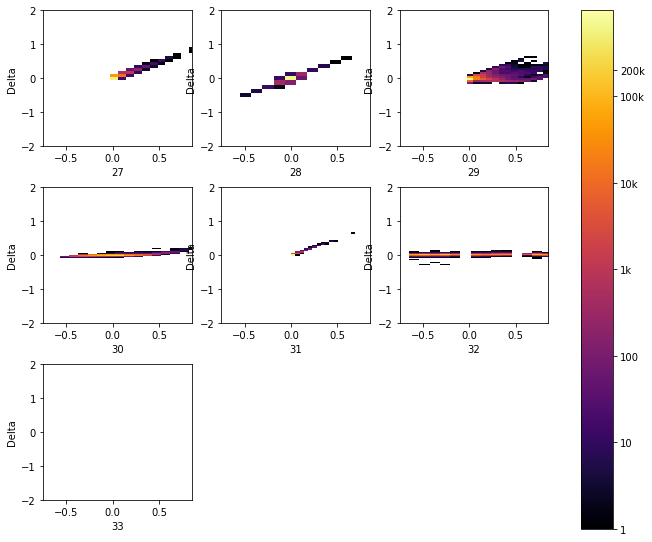

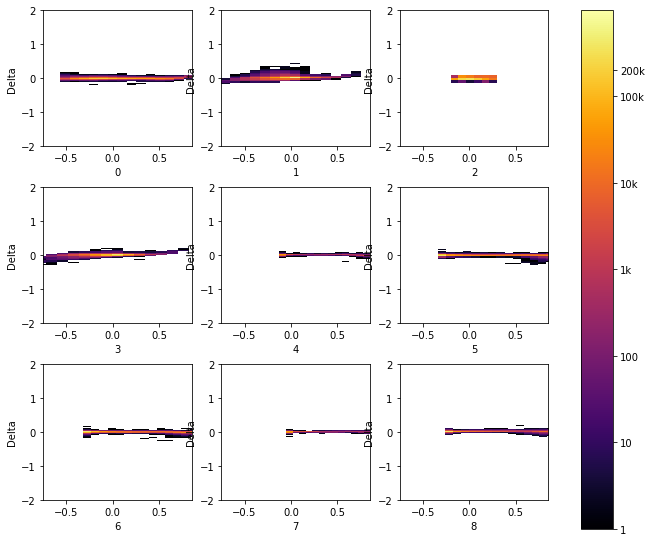

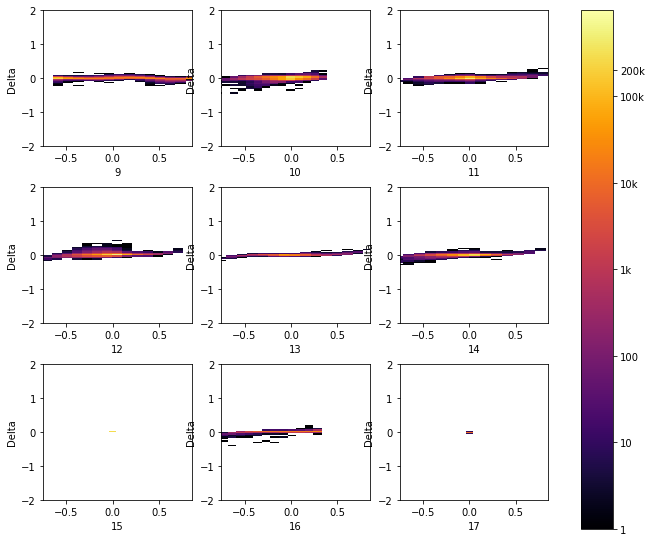

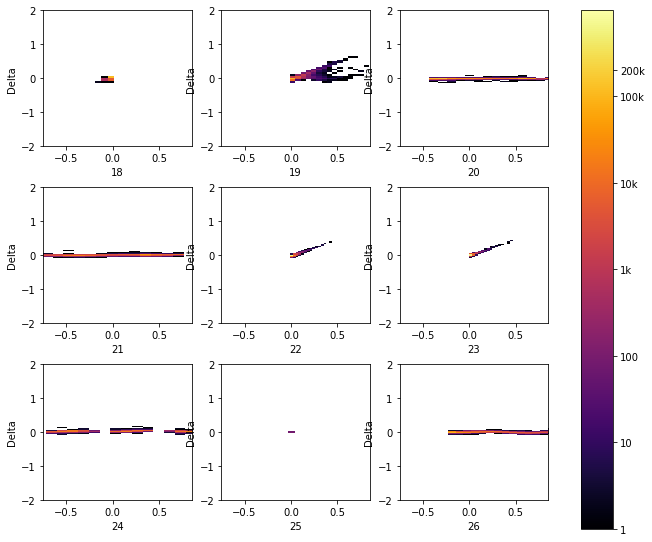

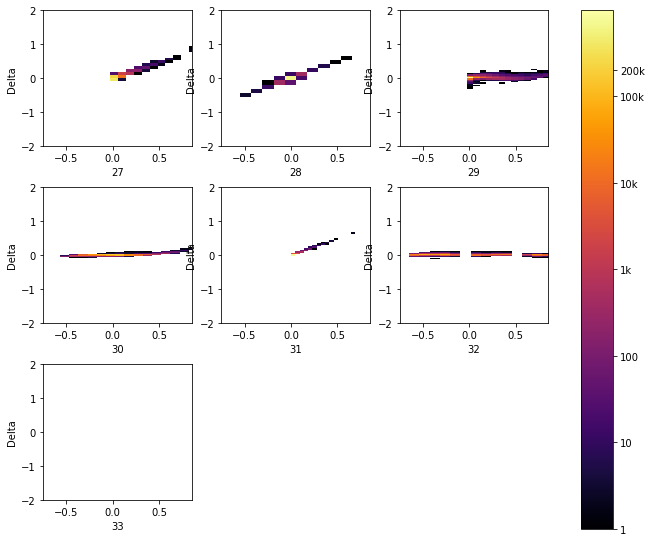

In [231]:
%%time
# The plots below show the difference between predictions to true scaled feature values 
# as a function of the true feature value. The closer the histograms are centered
# around the line y=0, the better the autoencoder has performed

l_minmax = [[-2, 2]] * n_compressed_features # The y limits
for encoding_dim in save_decoded_dict:
#for encoding_dim in [1]:
    plot_difference_displ(
        TYPE, pd.DataFrame(save_decoded_dict[encoding_dim]), pd.DataFrame(test_input), 
        encoding_dim, Transform=False, SetMinMax=True, FTS_SCLD=True, l_minmax=l_minmax, save_dir="img",
        save_filename="FeatureDeviation_{}_{}.png".format(encoding_dim, TYPE)
    )

Распределения значений фич до и после автоэнкодера

******************** 1 ********************


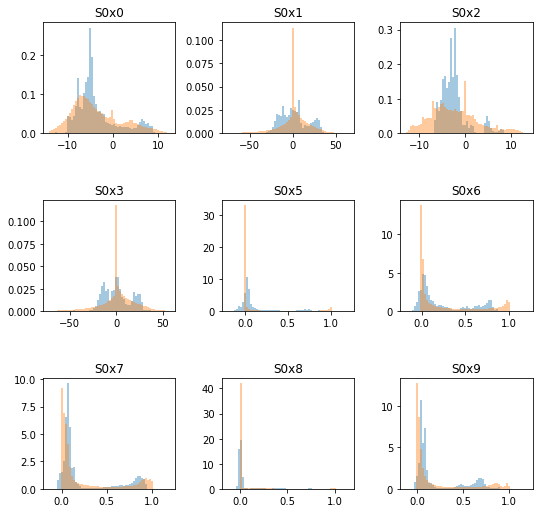

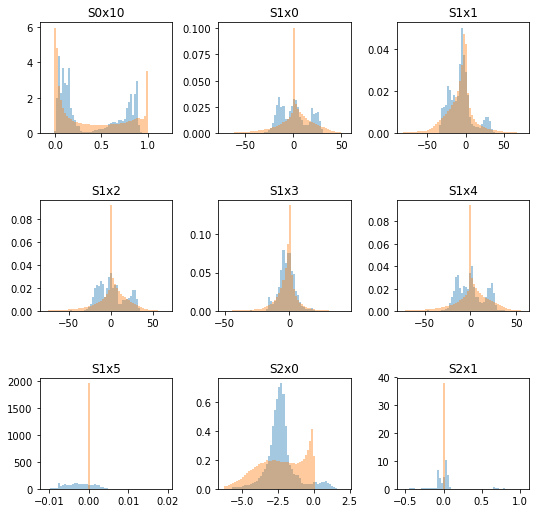

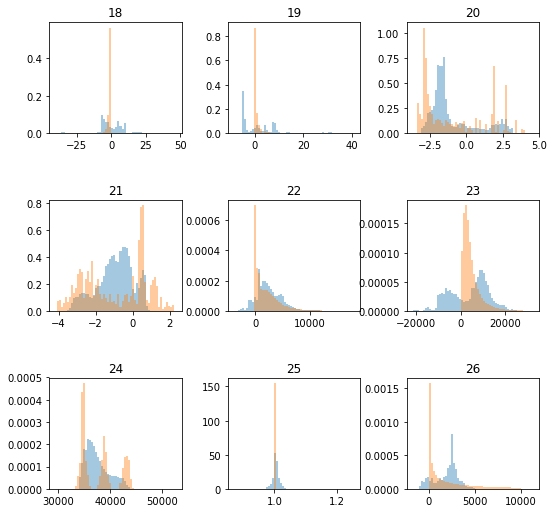

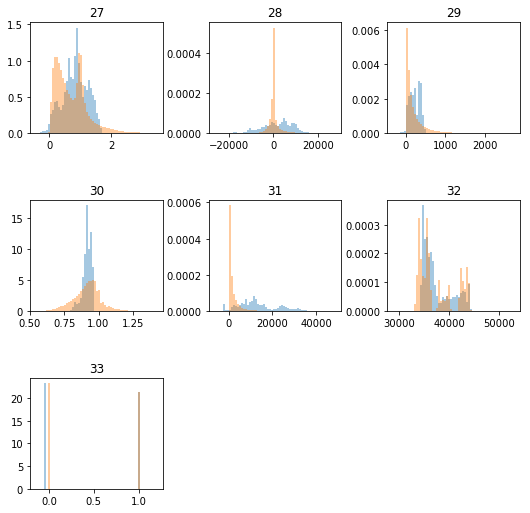

******************** 3 ********************


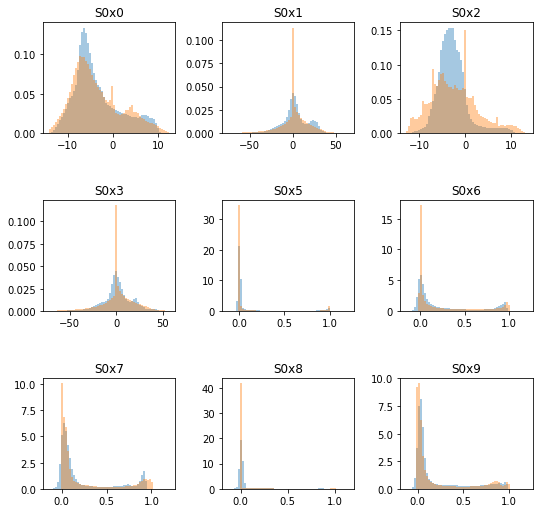

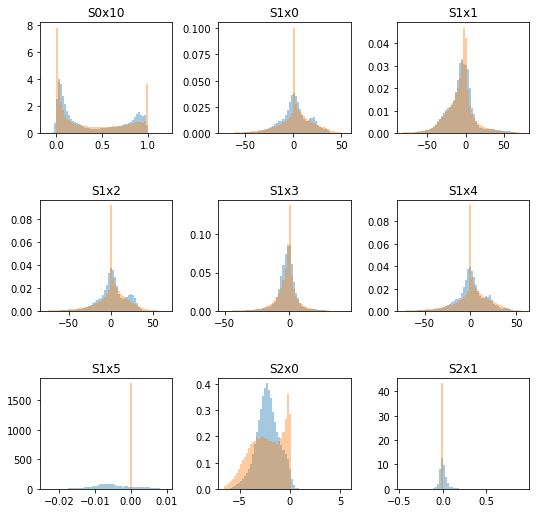

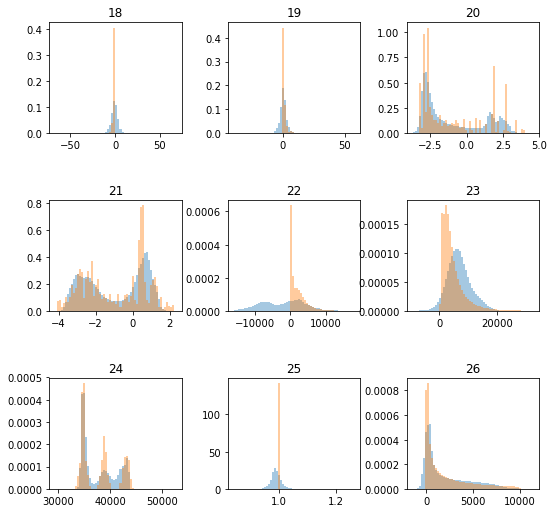

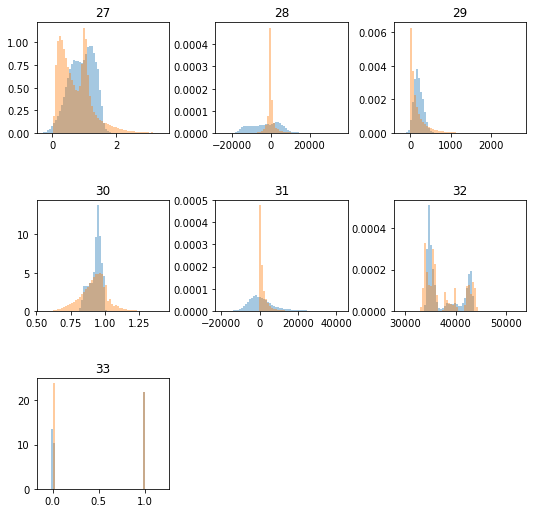

******************** 6 ********************


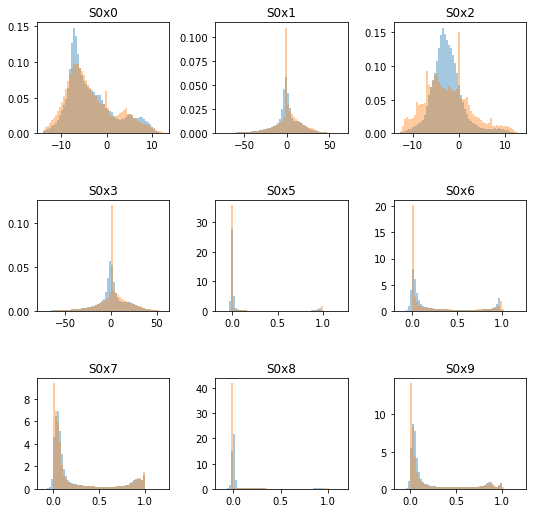

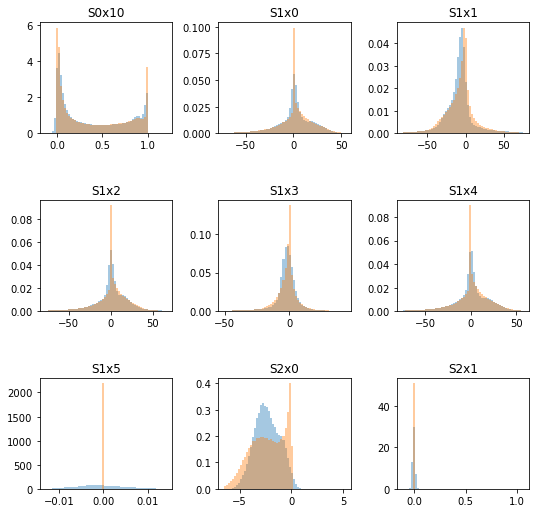

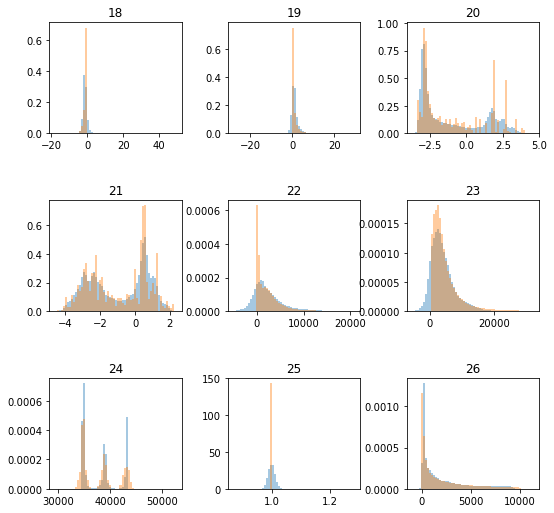

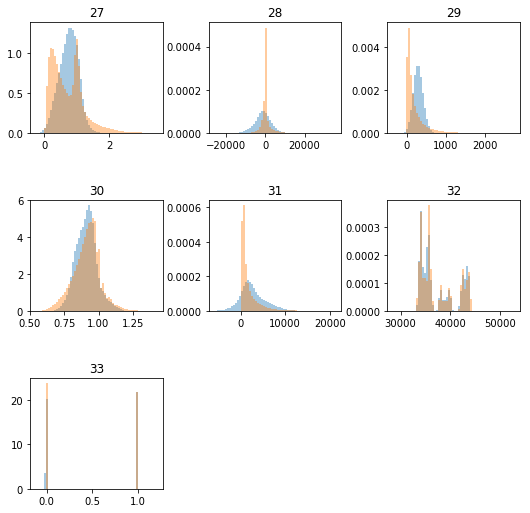

******************** 9 ********************


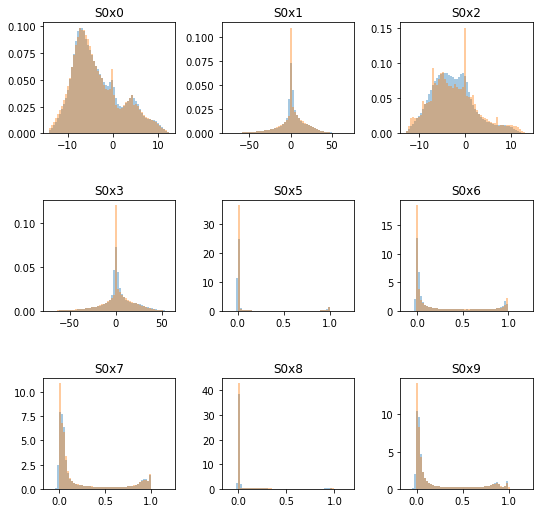

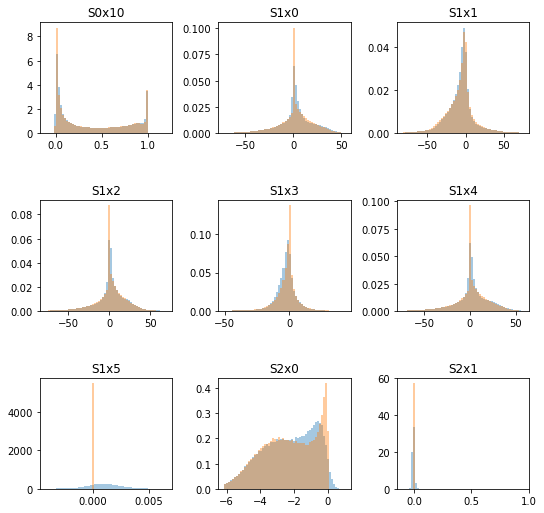

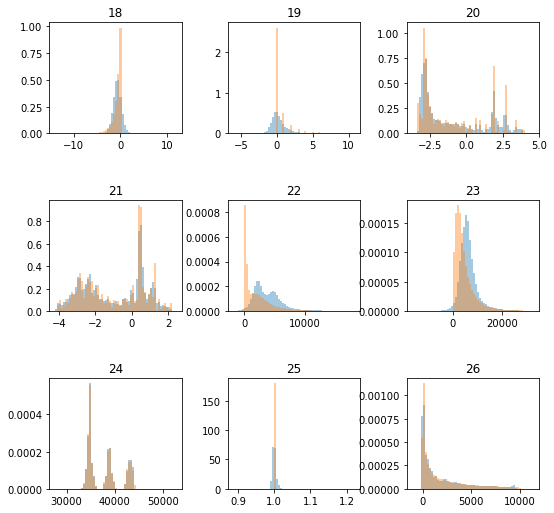

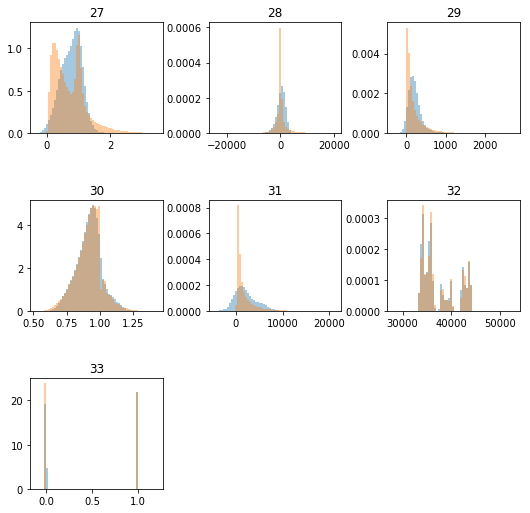

******************** 12 ********************


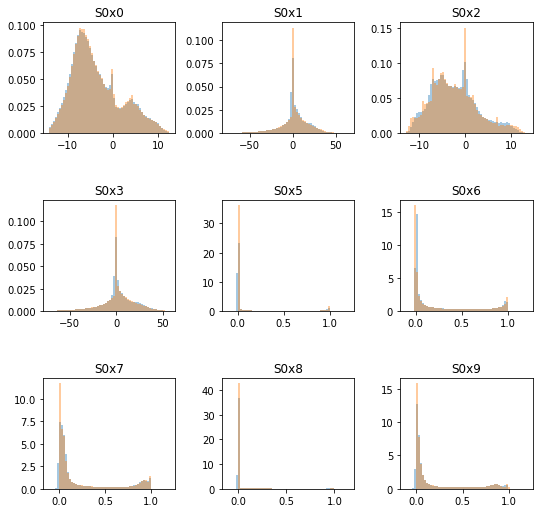

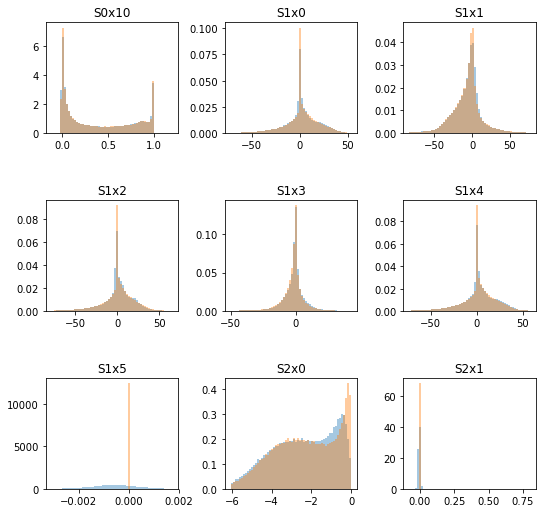

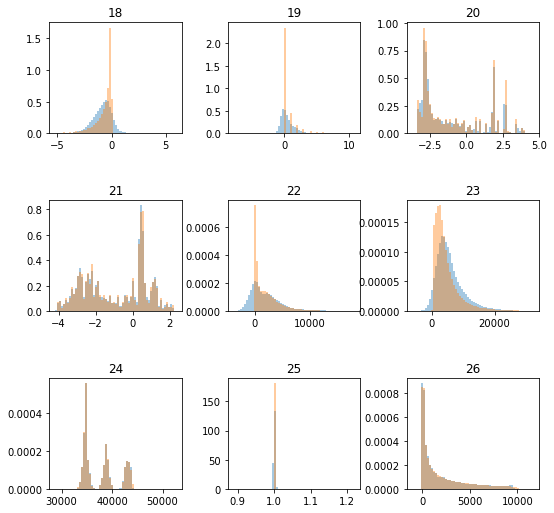

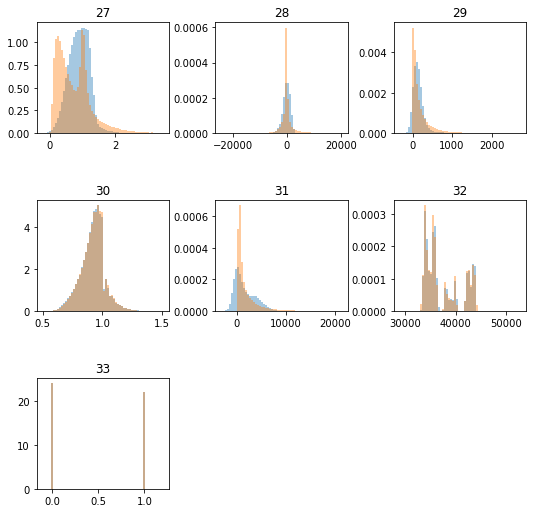

******************** 15 ********************


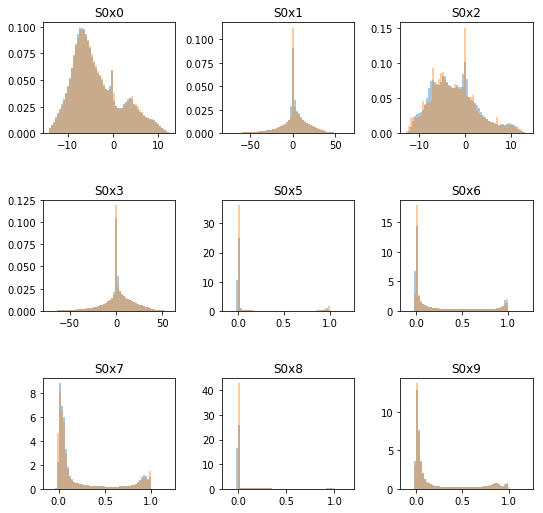

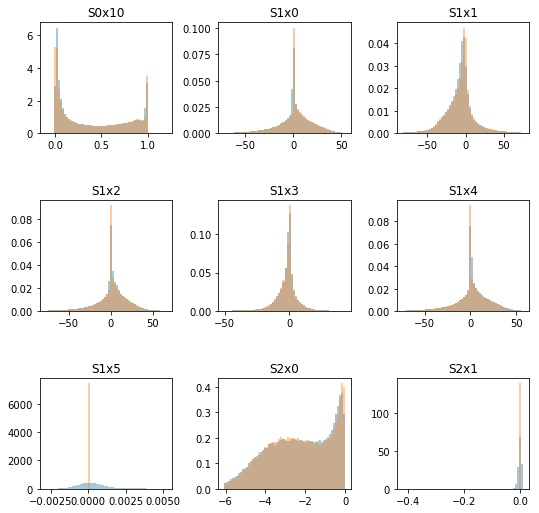

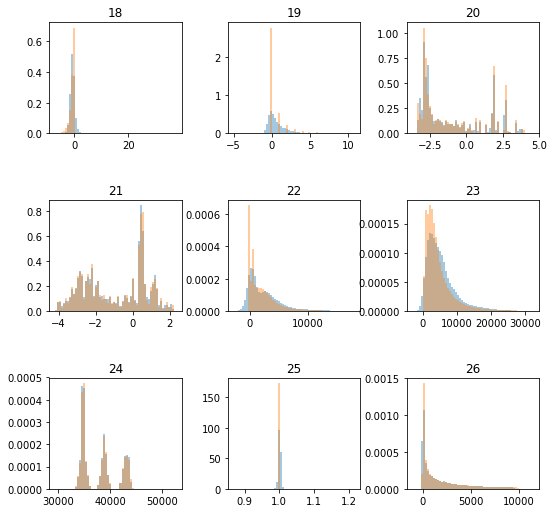

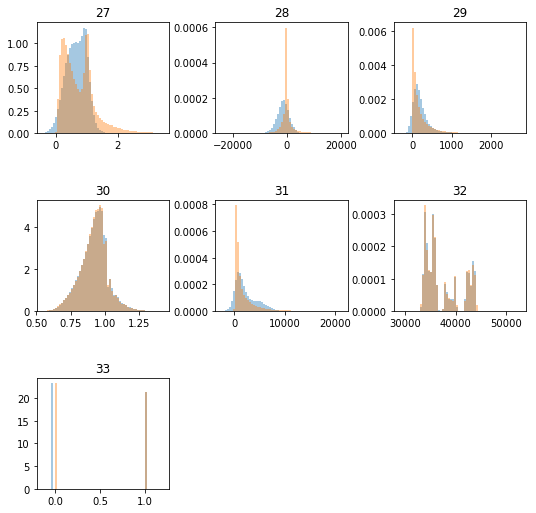

******************** 18 ********************


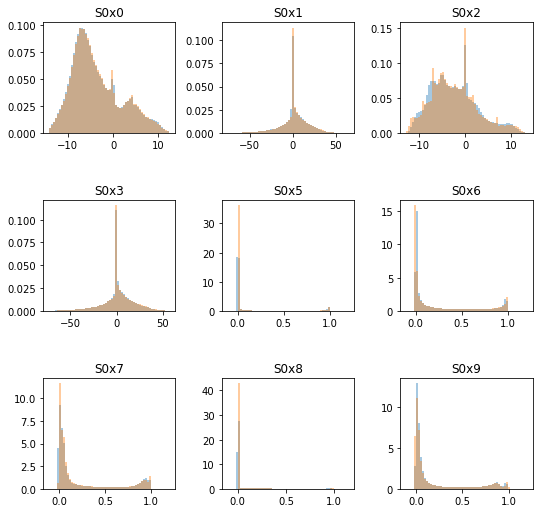

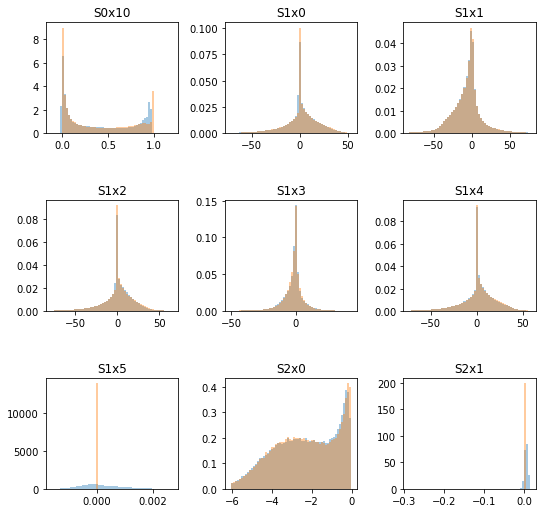

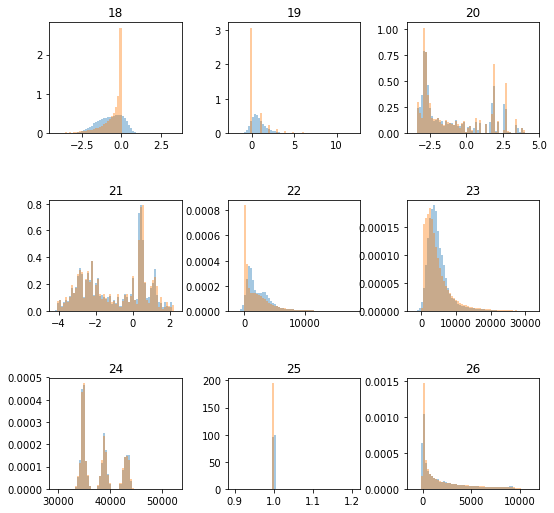

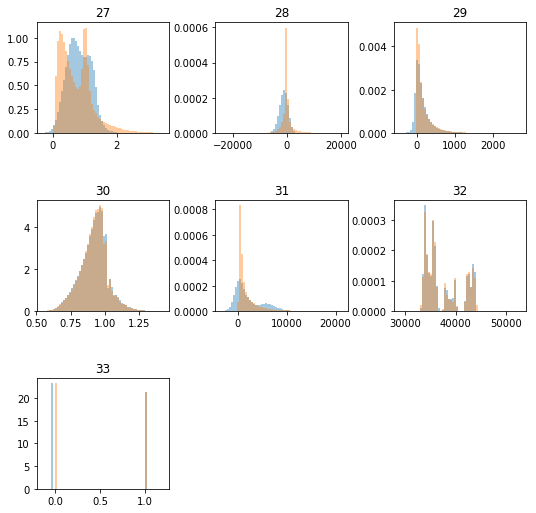

In [232]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in save_decoded_dict:
    # if you don't care about the names of the features uncomment the following line
#     print_features_histograms(
#         pd.DataFrame(save_decoded_dict_dec[encoding_dim]), 
#         target=pd.DataFrame(test_input_dec)
#     )
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim])
    df_temp_input = pd.DataFrame(test_input_dec)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, save_dir="img",
        save_filename="_{}_orig_uncom_distribs_{}.png".format(encoding_dim, TYPE)
    )
    plt.show()

Зависимость MSE от encoding_dim

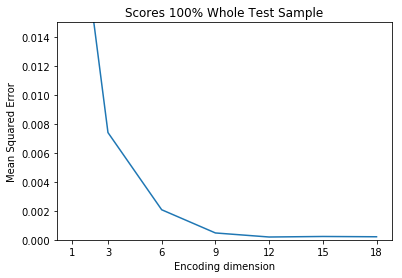

In [239]:
# Plotting the training loss (linear plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.plot(l_encoding_dim, l_score)
plt.title("Scores 100% Whole Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0, 0.015)
plt.savefig("./img/scores_{}.png".format(TYPE))

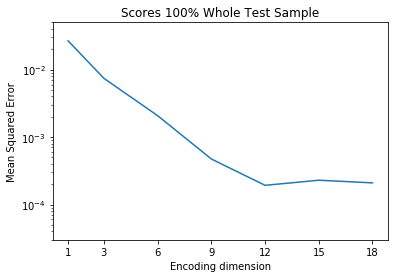

In [251]:
# Plotting the training loss (log plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.semilogy(l_encoding_dim, l_score)
plt.title("Scores 100% Whole Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0.00003, 0.05)
plt.savefig("./img/scores_log_{}.png".format(TYPE))

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Тестирование автоэнкодера на задаче классификации

In [252]:
# Save
def _transform_val(v):
    if isinstance(v, dict):
        return {kk: list(vv) if isinstance(vv, np.ndarray) else vv 
                for kk, vv in v.items()}
    elif isinstance(v, np.ndarray):
        return list(v)
    else:
        return v
    
def dump(saved_dict, folder, name):
    """ Save a 'saved_dict' to .json in 'folder' with 'name'.
    
    Params
    ------
        saved_dict : dict, {'encoding_dim' : [metric_value, ...]} or 
                           {'pid_label' : {'encoding_dim' : [metric_value, ...]} }
            Dict of a metric. 
    """
    dict_for_json = {k: _transform_val(v) for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json


def get_last_dir_n(path_to_metrics, metrics_dir_name):
    """ Return the highest number of folders which name == number"""
    try:
        last_folder_n = max(list(map(lambda name: int(name.split('_')[-1]), 
                                     filter(lambda name: os.path.isdir(os.path.join(path_to_metrics, name)) 
                                            and name.split('_')[-1].isdecimal(), os.listdir(path_to_metrics)))))
    except:
        last_folder_n = None
        
    return last_folder_n


def create_metrics_folder(path_to_metrics, metrics_dir_name):
    """ Create new folder for metrics in 'metrics_path' dir.
    Return
    ------
        new_folder : str
            Path to new folder.
        old_folder : str
            Path to prev folder.
    """
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    if last_folder_n is None:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_0')
        old_folder = None
    else:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n + 1))
        old_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    os.makedirs(new_folder)
    
    return new_folder, old_folder


def dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict):
    """ Save all metrics from 'metrics_dict' to .json files.
        Save in 'path_to_metrics' + 'metrics_dir_name' + '_' + str(version) dir 
        to new folder and delete prev version.
        
    Params
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    folder, old_folder = create_metrics_folder(path_to_metrics, metrics_dir_name)
    print(folder)

    for metric_name, metric_values in metrics_dict.items():
        dump(metric_values, folder, metric_name)
    
    if old_folder is not None:
        shutil.rmtree(old_folder, ignore_errors=True)

In [253]:
# Load
def load_metrics(path_to_metrics, metrics_dir_name):
    """
    Return
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    metrics_dict = {}
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics_dict[file_name[:-5]] = json.load(file)
    return metrics_dict

In [255]:
def plot_metrics(metrics_dict, pid_label=0, xlim=(0, 1), ylim=(0, 1)):
    plt.figure(figsize=(15, 7))
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow', 'orange', 'coral']
    # ROC AUC
    plt.subplot(1, 2, 1)
    for i, encoding_dim in enumerate(metrics_dict['fpr'].keys()):
        plt.plot(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['roc_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC AUC")
    plt.savefig("./img/ROC_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    
    # PR AUC
    plt.subplot(1, 2, 2)
    for i, encoding_dim in enumerate(metrics_dict['precision'].keys()):
        plt.plot(
            metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} PR AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['pr_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="lower left")
    plt.title("PR AUC")
    plt.savefig("./img/PR_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    plt.show()

In [256]:
le = LabelEncoder()
y = le.fit_transform(test_MC[:, 0])

In [257]:
test_input.shape, y.shape, test_MC.shape, test.shape

((981692, 34), (981692,), (981692, 1), (981692, 50))

In [258]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(test_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = test_input[idx_train_clf], test_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_dec_dict, X_test_dec_dict = {}, {}
for encoding_dim in l_encoding_dim:
    # Input None -> decoded None
    save_decoded_dict[encoding_dim][test_mask^True] = np.nan
    
    X_train_dec_dict[encoding_dim] = save_decoded_dict[encoding_dim][idx_train_clf]
    X_test_dec_dict[encoding_dim] = save_decoded_dict[encoding_dim][idx_test_clf]

In [259]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [260]:
path_to_metrics = './metrics/'
metrics_dir_name = 'whole_data__std_maxabs__4_layers__equal_n_units__double_decoded_with_Nones'

In [261]:
clf_encoding_dim = ["orig"] + l_encoding_dim
n_repeats = np.ones_like(clf_encoding_dim, dtype=int)
n_evals_for_dim = np.zeros_like(clf_encoding_dim, dtype=int)

In [262]:
n_repeats, n_evals_for_dim

(array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]))

Run time: 2299.44 sec
n_evals_for_dim:  [1 1 1 1 1 1 1 1]


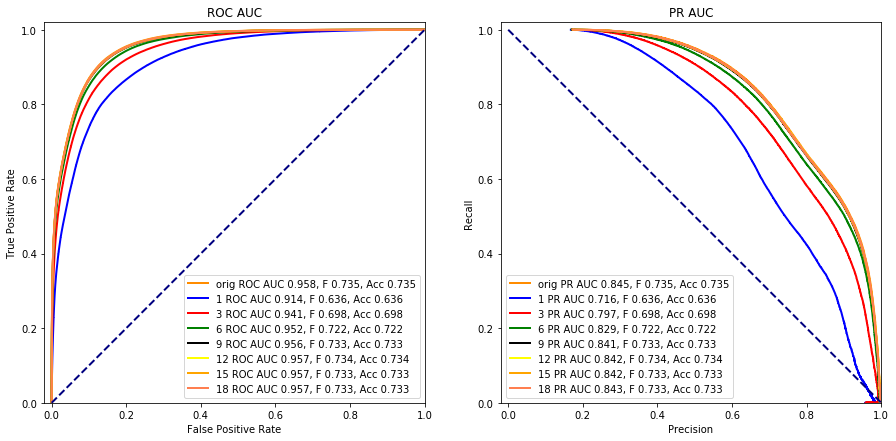

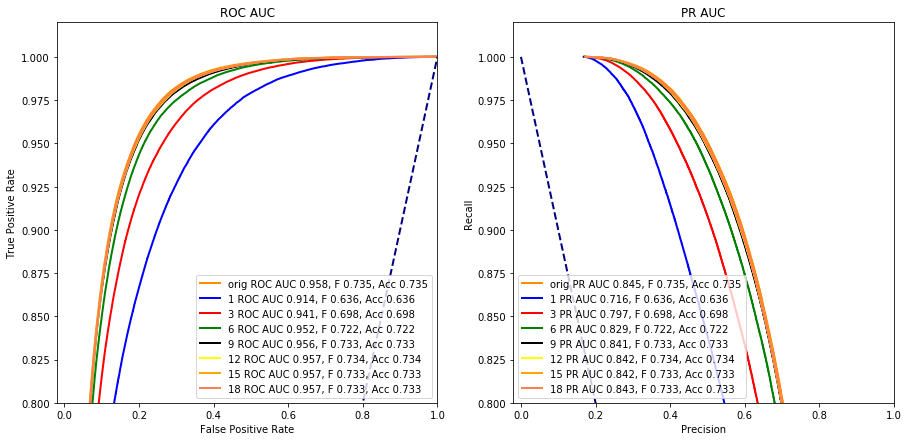

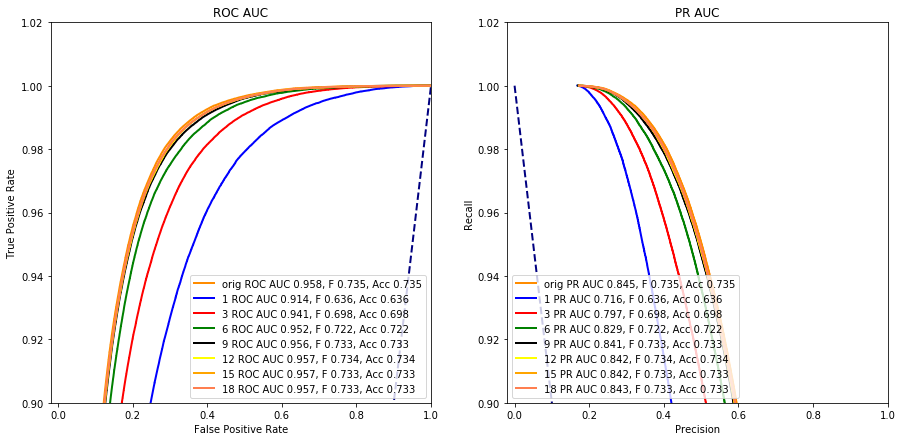

8it [5:37:08, 2527.98s/it]

CPU times: user 5h 34min 32s, sys: 6min 49s, total: 5h 41min 21s
Wall time: 5h 37min 8s


In [263]:
%%time
while np.sum(n_repeats - n_evals_for_dim) > 0:
    for i, encoding_dim in tqdm(enumerate(clf_encoding_dim)):
        if n_evals_for_dim[i] >= n_repeats[i]:
            continue
        clf = xgb.XGBClassifier(nthread=-1, seed=111)

        # fit model and predict probas
        start_time = timeit.default_timer()
        if encoding_dim == "orig":
            clf.fit(X_train, y_train)
            y_proba = clf.predict_proba(X_test)
        else:
            clf.fit(X_train_dec_dict[encoding_dim], y_train)
            y_proba = clf.predict_proba(X_test_dec_dict[encoding_dim])
        y_pred = np.argmax(y_proba, axis=1)
        y_bin = label_binarize(y_test, classes=np.unique(y_test))
        run_time = timeit.default_timer() - start_time

        # Compute ROC/PR curve and ROC/PR area for each class
        for pid_label in np.unique(y_test):
            idx = np.where(y_test == pid_label)[0]
            cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
            cur_y_proba = y_proba[:, pid_label]

            pid_label = str(pid_label)
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
                roc_curve(cur_y, cur_y_proba)
            metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
                precision_recall_curve(cur_y, cur_y_proba)

        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
            roc_curve(y_bin.ravel(), y_proba.ravel())
        metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
            precision_recall_curve(y_bin.ravel(), y_proba.ravel())

        metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
            metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
        metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())

        metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
        metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)

        # Save
        dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
        n_evals_for_dim[i] += 1

        # Plot
        display.clear_output(wait=True)
        print("Run time: {:.2f} sec".format(run_time))
        print('n_evals_for_dim: ', n_evals_for_dim)
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

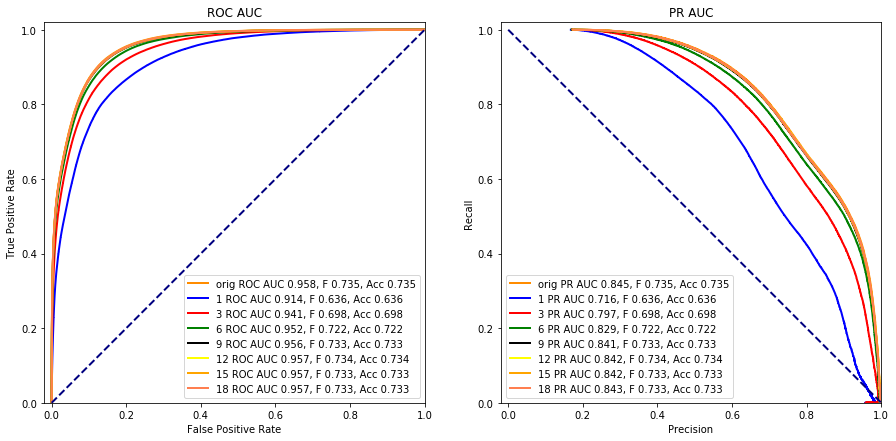

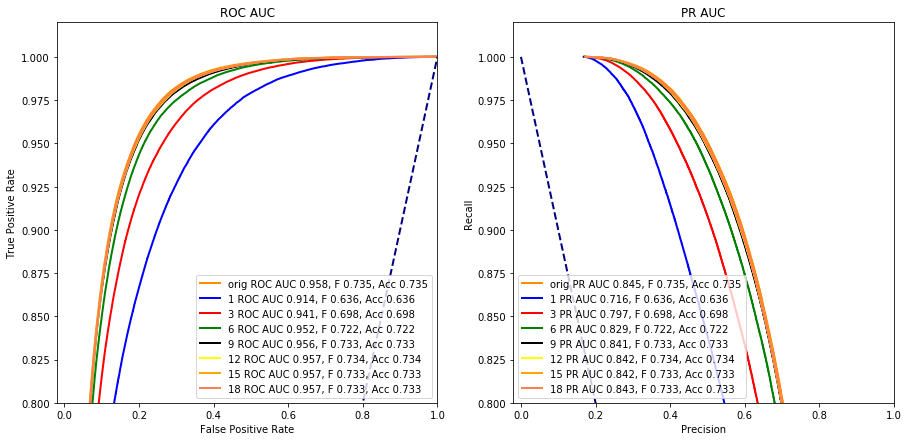

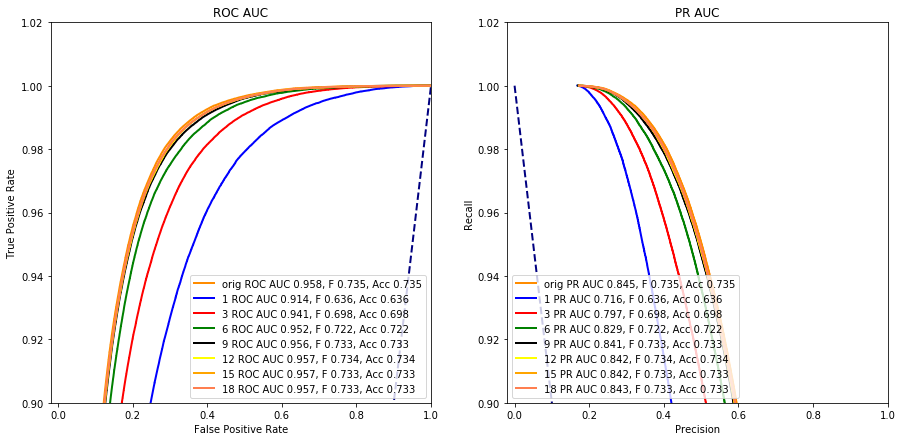

In [264]:
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

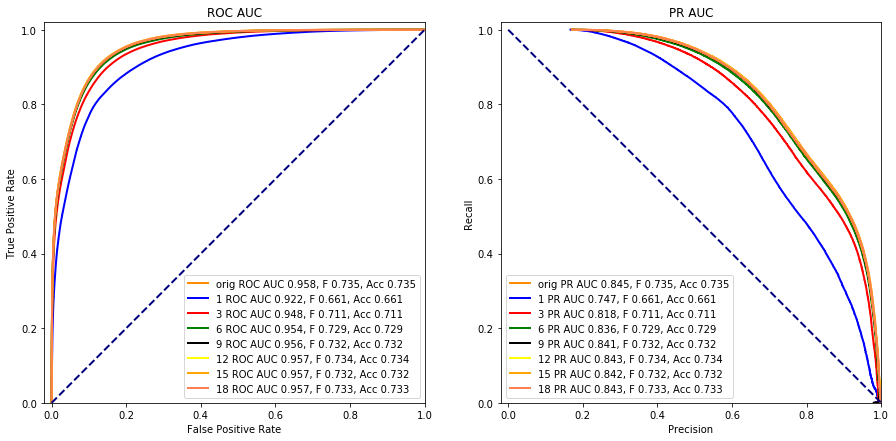

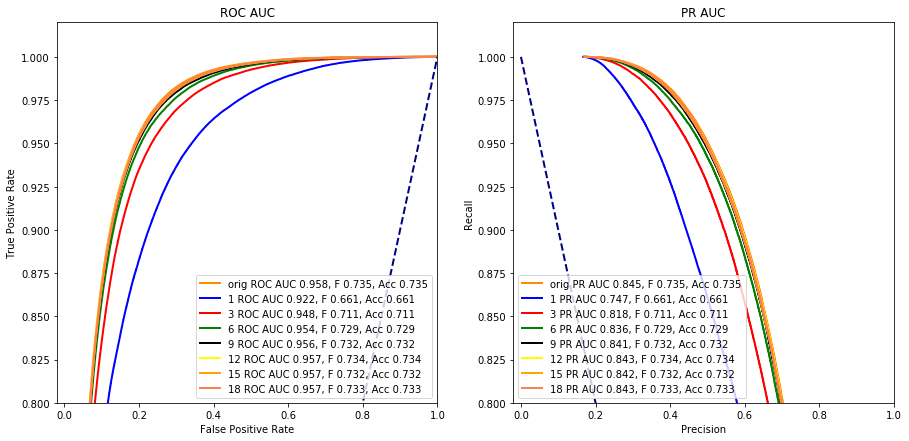

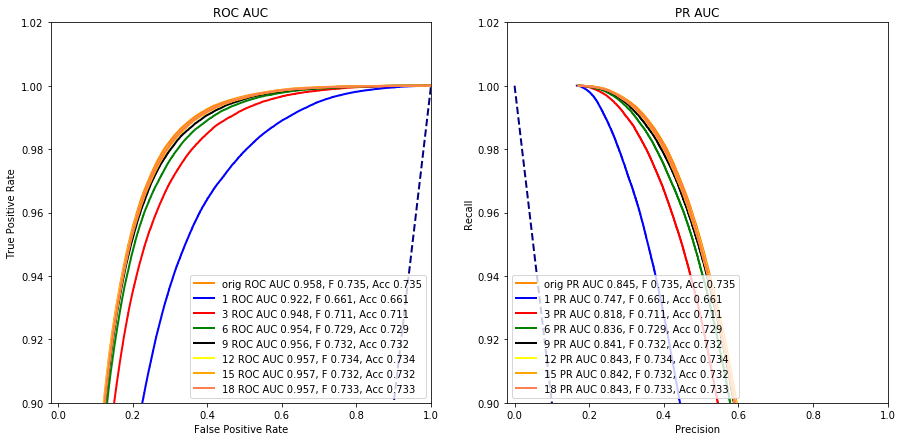

In [125]:
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

In [112]:
n_repeats, n_evals_for_dim

(array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]))